# Import Libraries

In [1]:
import gurobipy as grb
import pandas as pd
from gurobipy import GRB
import numpy as np

# Model

In [2]:
 # Create a model
model = grb.Model("Model")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-10


# Get data from json

In [3]:
# get the  data from the json file small.json
import json
with open('medium.json') as f:
    data = json.load(f)
# data

## Constants from data

In [4]:
horizon= data['horizon']
qualifications=data['qualifications']
staff_names=[i['name'] for i in data['staff']]
staff_qualifications=[i['qualifications'] for i in data['staff']]
job_list=[i['name'] for i in data['jobs']]
jour_list=[i for i in range(1,horizon+1)]
job_penality=[i['daily_penalty'] for i in data['jobs']] 
job_qualifications= [i['working_days_per_qualification'] for i in data['jobs']]
job_gain=[i['gain'] for i in data['jobs']]
due_dates=[i['due_date'] for i in data['jobs']]
vacation_staff=[i['vacations'] for i in data['staff']]

# Model's parameters

#### Objective 1
H : days

Q : qualifications

S : staff

J : jobs

qi : qualifications of i

qj : qualifications of j

vi : vacation days of i

njk : required work load for j with k

cj : daily penalty of j

gj : gain of j

dj : due date of j

yj : is j completely done

lj : delay in days for j

ej : end date of j

pi_j_k_t : work is done by i with k for j on t

#### Objective 2
aij : j is assigned to i

ni : number of jobs i works on

max_i : max of ni

### Objective 3
sj : start date for j

nj : length in days for j

max_j : maximum of nj

In [5]:
H = [i for i in range(1,horizon+1)]
Q = qualifications
S = staff_names
J = job_list
# Parameters for each staff

qi = {}
for i in range(len(staff_names)) :
    k = staff_names[i]
    qi[k] = []
    for c in qualifications:
        if c in data['staff'][i]['qualifications']:
            qi[k].append(c)
vi={}
for ind,i in enumerate(staff_names):
    vi[i] = []
    for j in jour_list:
        if j in vacation_staff[ind]:
            vi[i].append(j)
#vi=staff_in_vacation.to_dict(orient='index')

# Parameters for each job
qj = dict()
for ind, j in enumerate(job_list):
    qj[j] = list(job_qualifications[ind].keys())
njk = dict(zip(job_list,job_qualifications))
cj=job_penality_dict=dict(zip(job_list,job_penality))
gj=job_gain_dict=dict(zip(job_list,job_gain))
dj = dict(zip(job_list,due_dates))


# Decision variables

In [6]:
# Objective 1
pijkt = model.addVars(staff_names,job_list,qualifications,jour_list, vtype=GRB.BINARY, name="pijkt")

yj = model.addVars(job_list, vtype=GRB.BINARY, name="yj")
lj = model.addVars(job_list, vtype=GRB.INTEGER, name="lj")
ej = model.addVars(job_list, vtype=GRB.INTEGER, name="ej")

# Objective 2
max_i = model.addVar(vtype=GRB.INTEGER, name="max_i")
ni = model.addVars(S, vtype=GRB.INTEGER, name="ni")
aij = model.addVars(S, J, vtype=GRB.BINARY, name="aij")

# Objective 3
sj = model.addVars(J, vtype=GRB.INTEGER, name="sj")
nj = model.addVars(J, vtype=GRB.INTEGER, name="nj")
max_j = model.addVar(vtype=GRB.INTEGER, name="max_j")

# Constraints

### Objective 1

In [7]:
constr1 = {f'constr1{i}_{t}':model.addConstr( grb.quicksum(pijkt[i,j,k,t] for j in J for k in Q) <= 1 , name=f"constr1{i}_{t}")
  for i in S
  for t in H}

constr2 = {f'constr2{i}_{t}':model.addConstr( grb.quicksum(pijkt[i,j,k,t] for j in J for k in Q) == 0 , name=f"constr2{i}_{t}")
  for i in S
  for t in vi[i]}

constr3 = {f'constr3{i}_{j}_{k}_{t}':model.addConstr( pijkt[i,j,k,t] == 0 , name=f"constr3{i}_{j}_{k}_{t}")
  for i in S
  for j in J
  for k in Q if k not in qj[j] or k not in qi[i]
  for t in H}

constr4 = {f'constr4{j}_{k}': model.addConstr( yj[j]*njk[j][k] <= grb.quicksum(pijkt[i,j,k,t] for i in S for t in H) , name=f"constr4{j}_{k}")
  for j in J
  for k in qj[j]}

constr5 = {f'constr5{j}_{k}': model.addConstr( grb.quicksum(pijkt[i,j,k,t] for i in S for t in H) <= njk[j][k] , name=f"constr5{j}_{k}")
  for j in J
  for k in qj[j]}

constr6 = {f'constr6{i}_{j}_{k}_{t}':model.addConstr( pijkt[i,j,k,t]*t <= ej[j] , name=f"constr6{i}_{j}_{k}_{t}")
  for i in S
  for j in J
  for k in Q
  for t in H}

constr7 = {f'constr7{j}' : model.addConstr( ej[j] - dj[j] <= lj[j] , name =f"constr7{j}")
  for j in J}

constr8 = {f'constr8{j}' : model.addConstr( 1 <= ej[j] , name =f"constr8{j}")
  for j in J}

constr9 = {f'constr9{j}' : model.addConstr( ej[j] <= H[-1] , name =f"constr9{j}")
  for j in J}

### Objective 2

In [8]:
# assigned jobs to a staff member i is aij[i, j]
constr10 = {f'constr10{i}_{j}_{k}_{t}' : model.addConstr( pijkt[i,j,k,t] <= aij[i, j] , name = f"constr10{i}_{j}_{k}_{t}")
    for i in S
    for j in J
    for k in Q
    for t in H}

# number of jobs assigned to a staff member i is ni[i]
constr11 = {f'constr11{i}' : model.addConstr( grb.quicksum(aij[i, j] for j in J) <= ni[i] , name = f"constr11{i}")
    for i in S}

# max_i max number of jobs assigned to a staff member
# for all staff i, number of jobs assigned to i is less than or equal to max_i
constr12 = {f'constr12{i}' : model.addConstr( ni[i] <= max_i , name = f"constr12{i}")
    for i in S}

### Objective 3

In [9]:
# start date is at least 1
constr14 = {f'constr14_{j}' : model.addConstr( 1 <= sj[j] , name = f"constr14_{j}")
    for j in J}

# start date of j is sj[j]
constr15 = {f'constr15{i}_{j}_{k}_{t}' : model.addConstr( sj[j] <= t*pijkt[i,j,k,t] + H[-1]*(1-pijkt[i,j,k,t]) , name = f"constr15{i}_{j}_{k}_{t}")
    for i in S
    for j in J
    for k in Q
    for t in H}

# length of a job j is nj[j]
constr16 = {f'constr16{j}' : model.addConstr( ej[j] + 1 - sj[j] <= nj[j] , name = f"constr16{j}")
    for j in J}

# max_j max of nj[j]
constr17 = {f'constr17{j}' : model.addConstr( nj[j]  <= max_j , name = f"constr17{j}")
  for j in J  }

# Objectives

In [10]:
def filter_dominated_solutions(pareto, curr):
    
    #print(pareto)
    for sol in pareto:
        if all(curr[v] <= sol[v] for v in range(3)):
            return pareto
        elif all(curr[v] >= sol[v] for v in range(3)):
            pareto.remove(sol)

    pareto.append((curr[0],curr[1],curr[2]))
    return pareto

In [11]:
model.setParam('TimeLimit', 0.5*60)

Set parameter TimeLimit to value 30


In [12]:
eps2s = [i for i in range(len(J), 0, -1)]
eps3s = [i for i in range(len(H), 0, -1)]
pareto = []

for eps2 in eps2s:
    for eps3 in eps3s:
        print(eps2,eps3)
        # constraint for objective 2
        constrobj2 = model.addConstr( max_i <= eps2 , name = "constrobj2")
        constrobj4 = model.addConstr( max_i >= eps2 , name = "constrobj4")
        # constraint for objective 3
        constrobj3 = model.addConstr( max_j <= eps3 , name = "constrobj3")
        constrobj5 = model.addConstr( max_j >= eps3 , name = "constrobj5")

        # Objective 1
        model.setObjective( grb.quicksum((gj[j]*yj[j] - lj[j]*cj[j]) for j in J) , GRB.MAXIMIZE)

        # Paramétrage (mode mute)
        model.params.outputflag = 0
        # Résolution du PL
        
        try :
            model.optimize()
            #print(max_i,max_j,eps2,eps3)
            #print('parzeto',pareto)
            pareto = filter_dominated_solutions(pareto,(model.objVal, -eps2, -eps3))
            #pareto.append((model.objVal, eps2, eps3))
            model.remove(constrobj2)
            model.remove(constrobj3)
            model.remove(constrobj4)
            model.remove(constrobj5)
        except :
            print(eps2,eps3)

15 22
15 21
15 20
15 19
15 18
15 17
15 16
15 15
15 14
15 13
15 12
15 11
15 10
15 9
15 8
15 7
15 6
15 5
15 4
15 3
15 2
15 1
14 22
14 21
14 20
14 19
14 18
14 17
14 16
14 15
14 14
14 13
14 12
14 11
14 10
14 9
14 8
14 7
14 6
14 5
14 4
14 3
14 2
14 1
13 22
13 21
13 20
13 19
13 18
13 17
13 16
13 15
13 14
13 13
13 12
13 11
13 10
13 9
13 8
13 7
13 6
13 5
13 4
13 3
13 2
13 1
12 22
12 21
12 20
12 19
12 18
12 17
12 16
12 15
12 14
12 13
12 12
12 11
12 10
12 9
12 8
12 7
12 6
12 5
12 4
12 3
12 2
12 1
11 22
11 21
11 20
11 19
11 18
11 17
11 16
11 15
11 14
11 13
11 12
11 11
11 10
11 9
11 8
11 7
11 6
11 5
11 4
11 3
11 2
11 1
10 22
10 21
10 20
10 19
10 18
10 17
10 16
10 15
10 14
10 13
10 12
10 11
10 10
10 9
10 8
10 7
10 6
10 5
10 4
10 3
10 2
10 1
9 22
9 21
9 20
9 19
9 18
9 17
9 16
9 15
9 14
9 13
9 12
9 11
9 10
9 9
9 8
9 7
9 6
9 5
9 4
9 3
9 2
9 1
8 22
8 21
8 20
8 19
8 18
8 17
8 16
8 15
8 14
8 13
8 12
8 11
8 10
8 9
8 8
8 7
8 6
8 5
8 4
8 3
8 2
8 1
7 22
7 21
7 20
7 19
7 18
7 17
7 16
7 15
7 14
7 13
7 12
7 11


In [13]:
for ind,val in enumerate(pareto) :
    pareto[ind] = (val[0],-val[1],-val[2])
pareto

[(413.00000023201954, 11, 9),
 (380.0, 9, 4),
 (380.0, 8, 4),
 (411.0, 7, 6),
 (406.0, 7, 5),
 (377.0, 7, 4),
 (265.0, 7, 3),
 (413.0, 6, 8),
 (411.0, 6, 7),
 (408.0, 6, 6),
 (392.0, 6, 5),
 (361.0, 6, 4),
 (253.0, 6, 3),
 (413.0, 5, 10),
 (410.0, 5, 8),
 (402.0, 5, 7),
 (395.0, 5, 6),
 (383.0, 5, 5),
 (347.0, 5, 4),
 (250.0, 5, 3),
 (405.0, 4, 12),
 (404.0, 4, 9),
 (400.0, 4, 8),
 (385.0, 4, 6),
 (347.0, 4, 5),
 (322.0, 4, 4),
 (225.0, 4, 3),
 (382.0, 3, 12),
 (374.0, 3, 10),
 (379.0, 3, 9),
 (370.0, 3, 8),
 (340.0, 3, 6),
 (322.0, 3, 5),
 (245.0, 3, 4),
 (195.0, 3, 3),
 (326.0, 2, 12),
 (325.0, 2, 9),
 (305.0, 2, 8),
 (245.0, 2, 6),
 (232.0, 2, 5),
 (210.0, 2, 4),
 (155.0, 2, 3),
 (194.0, 1, 12),
 (180.0, 1, 8),
 (130.0, 1, 6),
 (120.0, 1, 5),
 (90.0, 1, 4),
 (80.0, 1, 3),
 (30.0, 1, 2),
 (-0.0, 1, 1)]

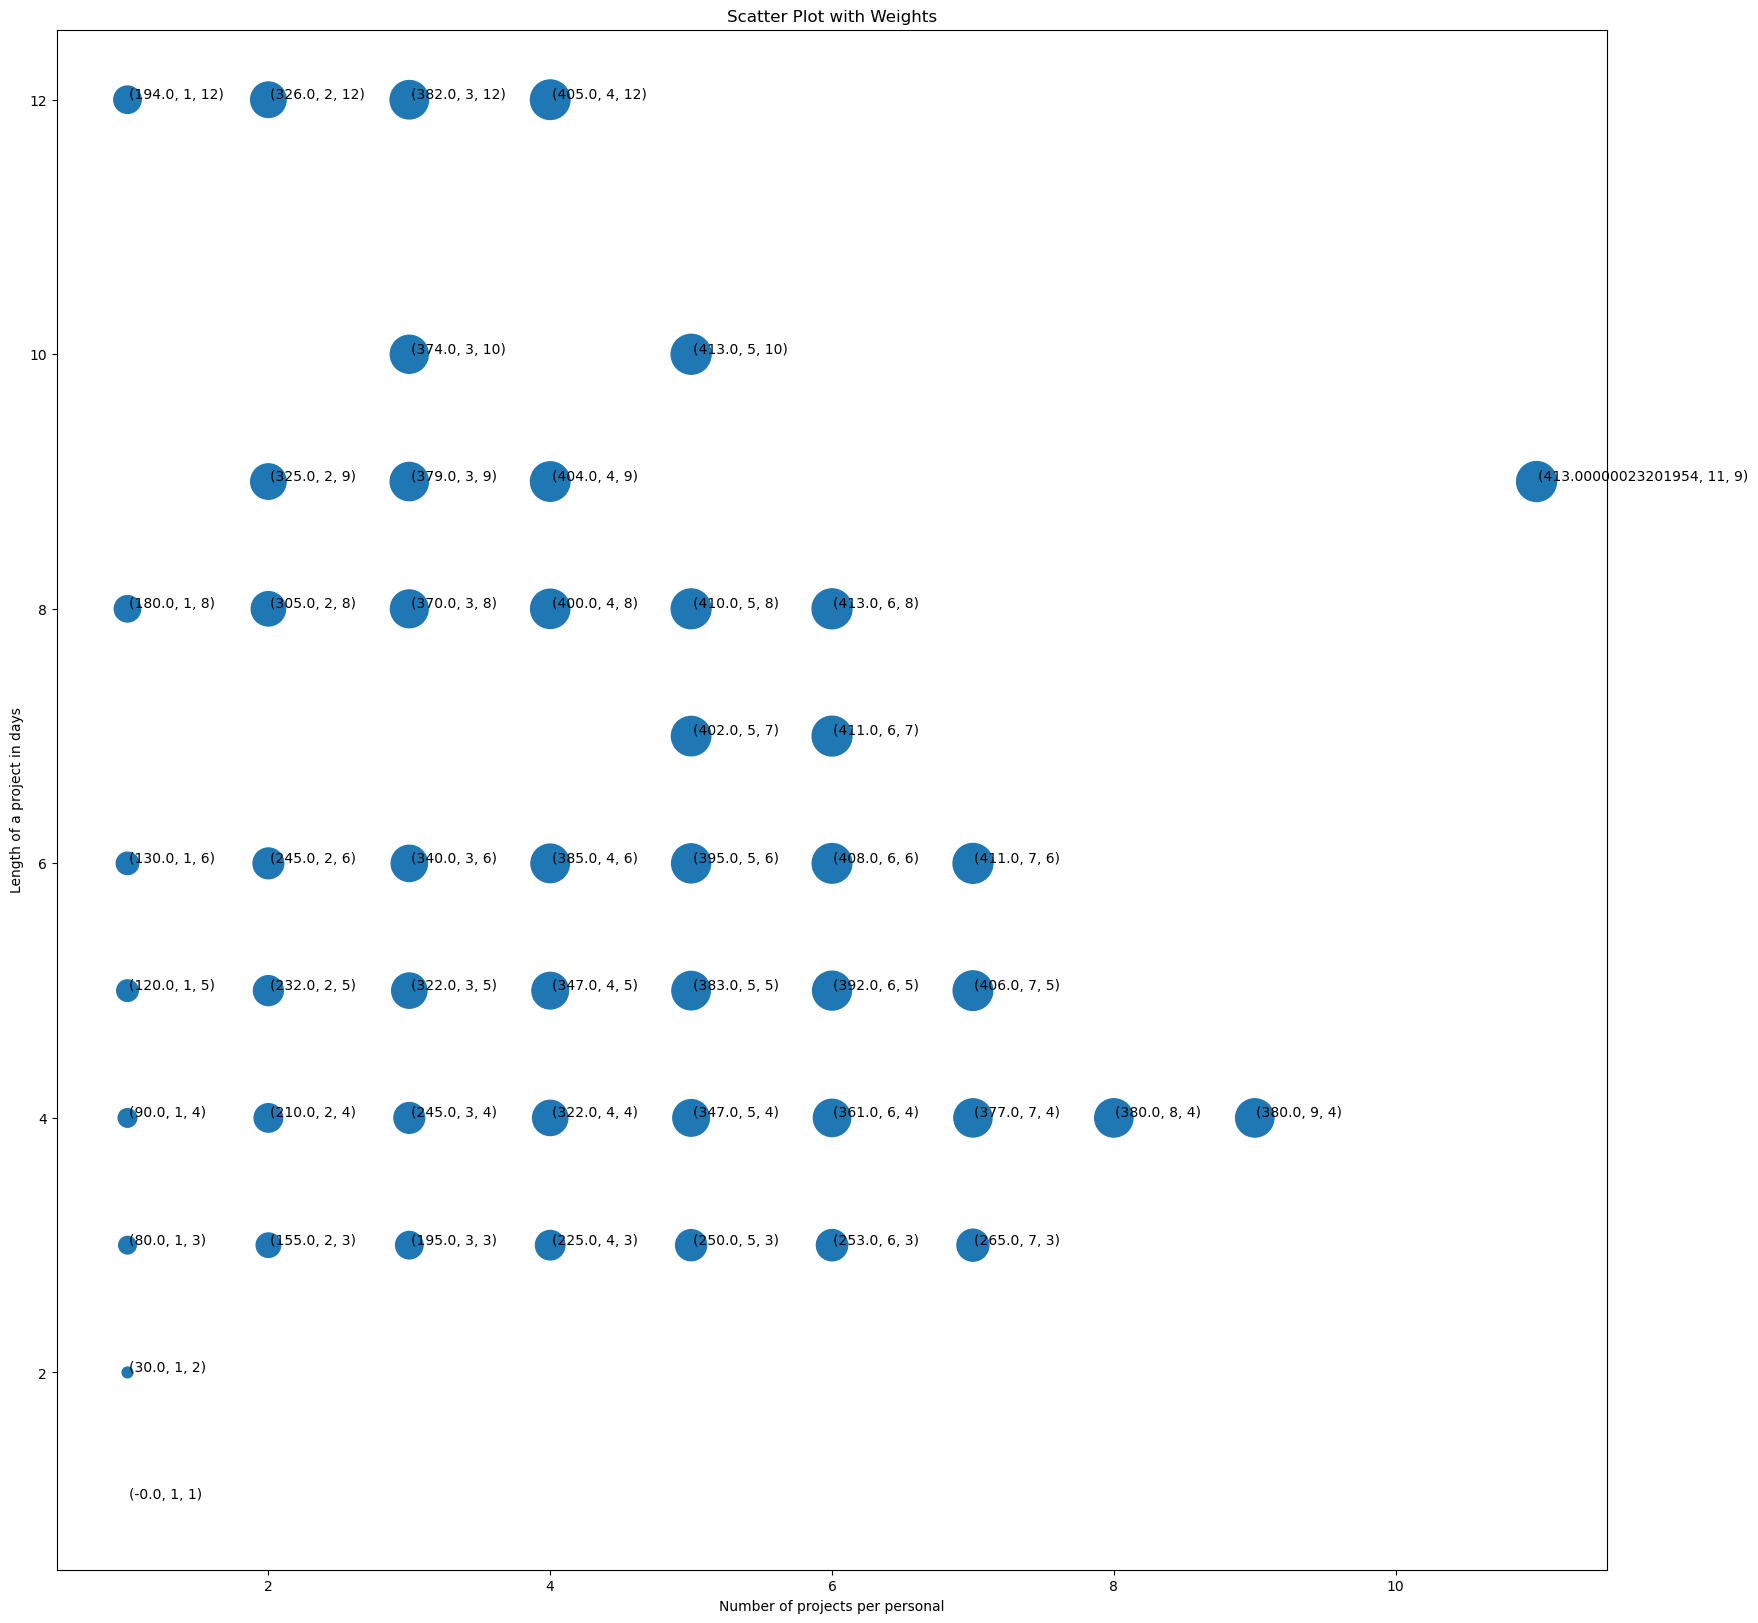

In [14]:
import matplotlib.pyplot as plt
# plot a 3d scatter with the pareto list print the labels of each point and set a different color for each point
fig = plt.figure(figsize=(20,20))
# Create the scatter plot
plt.scatter([i[1] for i in pareto], [i[2] for i in pareto],s = [i[0]*2 for i in pareto])
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.01, i[2]+0.01,  '%s' % (str(i)), size=10, zorder=1, color='k')
plt.title("Scatter Plot with Weights")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")

# Show the plot
plt.show()

In [26]:
for ind,val in enumerate(pareto) :
    pareto[ind] = (val[0],-val[1],-val[2])
print(pareto)

[(413.00000023201954, -11, -9), (380.0, -9, -4), (380.0, -8, -4), (411.0, -7, -6), (406.0, -7, -5), (377.0, -7, -4), (265.0, -7, -3), (413.0, -6, -8), (411.0, -6, -7), (408.0, -6, -6), (392.0, -6, -5), (361.0, -6, -4), (253.0, -6, -3), (413.0, -5, -10), (410.0, -5, -8), (402.0, -5, -7), (395.0, -5, -6), (383.0, -5, -5), (347.0, -5, -4), (250.0, -5, -3), (405.0, -4, -12), (404.0, -4, -9), (400.0, -4, -8), (385.0, -4, -6), (347.0, -4, -5), (322.0, -4, -4), (225.0, -4, -3), (382.0, -3, -12), (374.0, -3, -10), (379.0, -3, -9), (370.0, -3, -8), (340.0, -3, -6), (322.0, -3, -5), (245.0, -3, -4), (195.0, -3, -3), (326.0, -2, -12), (325.0, -2, -9), (305.0, -2, -8), (245.0, -2, -6), (232.0, -2, -5), (210.0, -2, -4), (155.0, -2, -3), (194.0, -1, -12), (180.0, -1, -8), (130.0, -1, -6), (120.0, -1, -5), (90.0, -1, -4), (80.0, -1, -3), (30.0, -1, -2), (-0.0, -1, -1)]


# Preferences

In [22]:
# create max dictionary with max values of each objective
max_dict = {0: max([i[0] for i in pareto]), 1: max([i[1] for i in pareto]), 2: max([i[2] for i in pareto])}

# somme pondérée des objectifs
def score(sol, w_1, w_2, w_3):
    return w_1*sol[0]/max_dict[0] - w_2*sol[1]/max_dict[1] - w_3*sol[2]/max_dict[2]

pareto_scores = [round(score(sol, 3, 2, 1.05), 2) for sol in pareto]

# pareto_sorted is a dictionary with the score as key and the solution as value ordered by score descending order
pareto_sorted = {pareto_scores[i]: pareto[i] for i in range(len(pareto_scores))}
pareto_sorted = dict(sorted(pareto_sorted.items(), reverse=True))
pareto_sorted

{1.54: (385.0, 4, 6),
 1.48: (400.0, 4, 8),
 1.44: (370.0, 3, 8),
 1.42: (379.0, 3, 9),
 1.4: (340.0, 3, 6),
 1.37: (410.0, 5, 8),
 1.36: (322.0, 3, 5),
 1.35: (408.0, 6, 6),
 1.32: (392.0, 6, 5),
 1.3: (374.0, 3, 10),
 1.28: (411.0, 6, 7),
 1.26: (322.0, 4, 4),
 1.24: (406.0, 7, 5),
 1.22: (413.0, 5, 10),
 1.21: (325.0, 2, 9),
 1.19: (411.0, 7, 6),
 1.18: (382.0, 3, 12),
 1.16: (405.0, 4, 12),
 1.15: (305.0, 2, 8),
 1.12: (377.0, 7, 4),
 0.96: (380.0, 8, 4),
 0.95: (326.0, 2, 12),
 0.89: (245.0, 2, 6),
 0.88: (232.0, 2, 5),
 0.81: (210.0, 2, 4),
 0.77: (380.0, 9, 4),
 0.64: (225.0, 4, 3),
 0.61: (195.0, 3, 3),
 0.5: (155.0, 2, 3),
 0.48: (253.0, 6, 3),
 0.43: (180.0, 1, 8),
 0.39: (265.0, 7, 3),
 0.25: (120.0, 1, 5),
 0.24: (130.0, 1, 6),
 0.21: (413.00000023201954, 11, 9),
 0.18: (194.0, 1, 12),
 0.14: (80.0, 1, 3),
 0.12: (90.0, 1, 4),
 -0.14: (30.0, 1, 2),
 -0.27: (-0.0, 1, 1)}

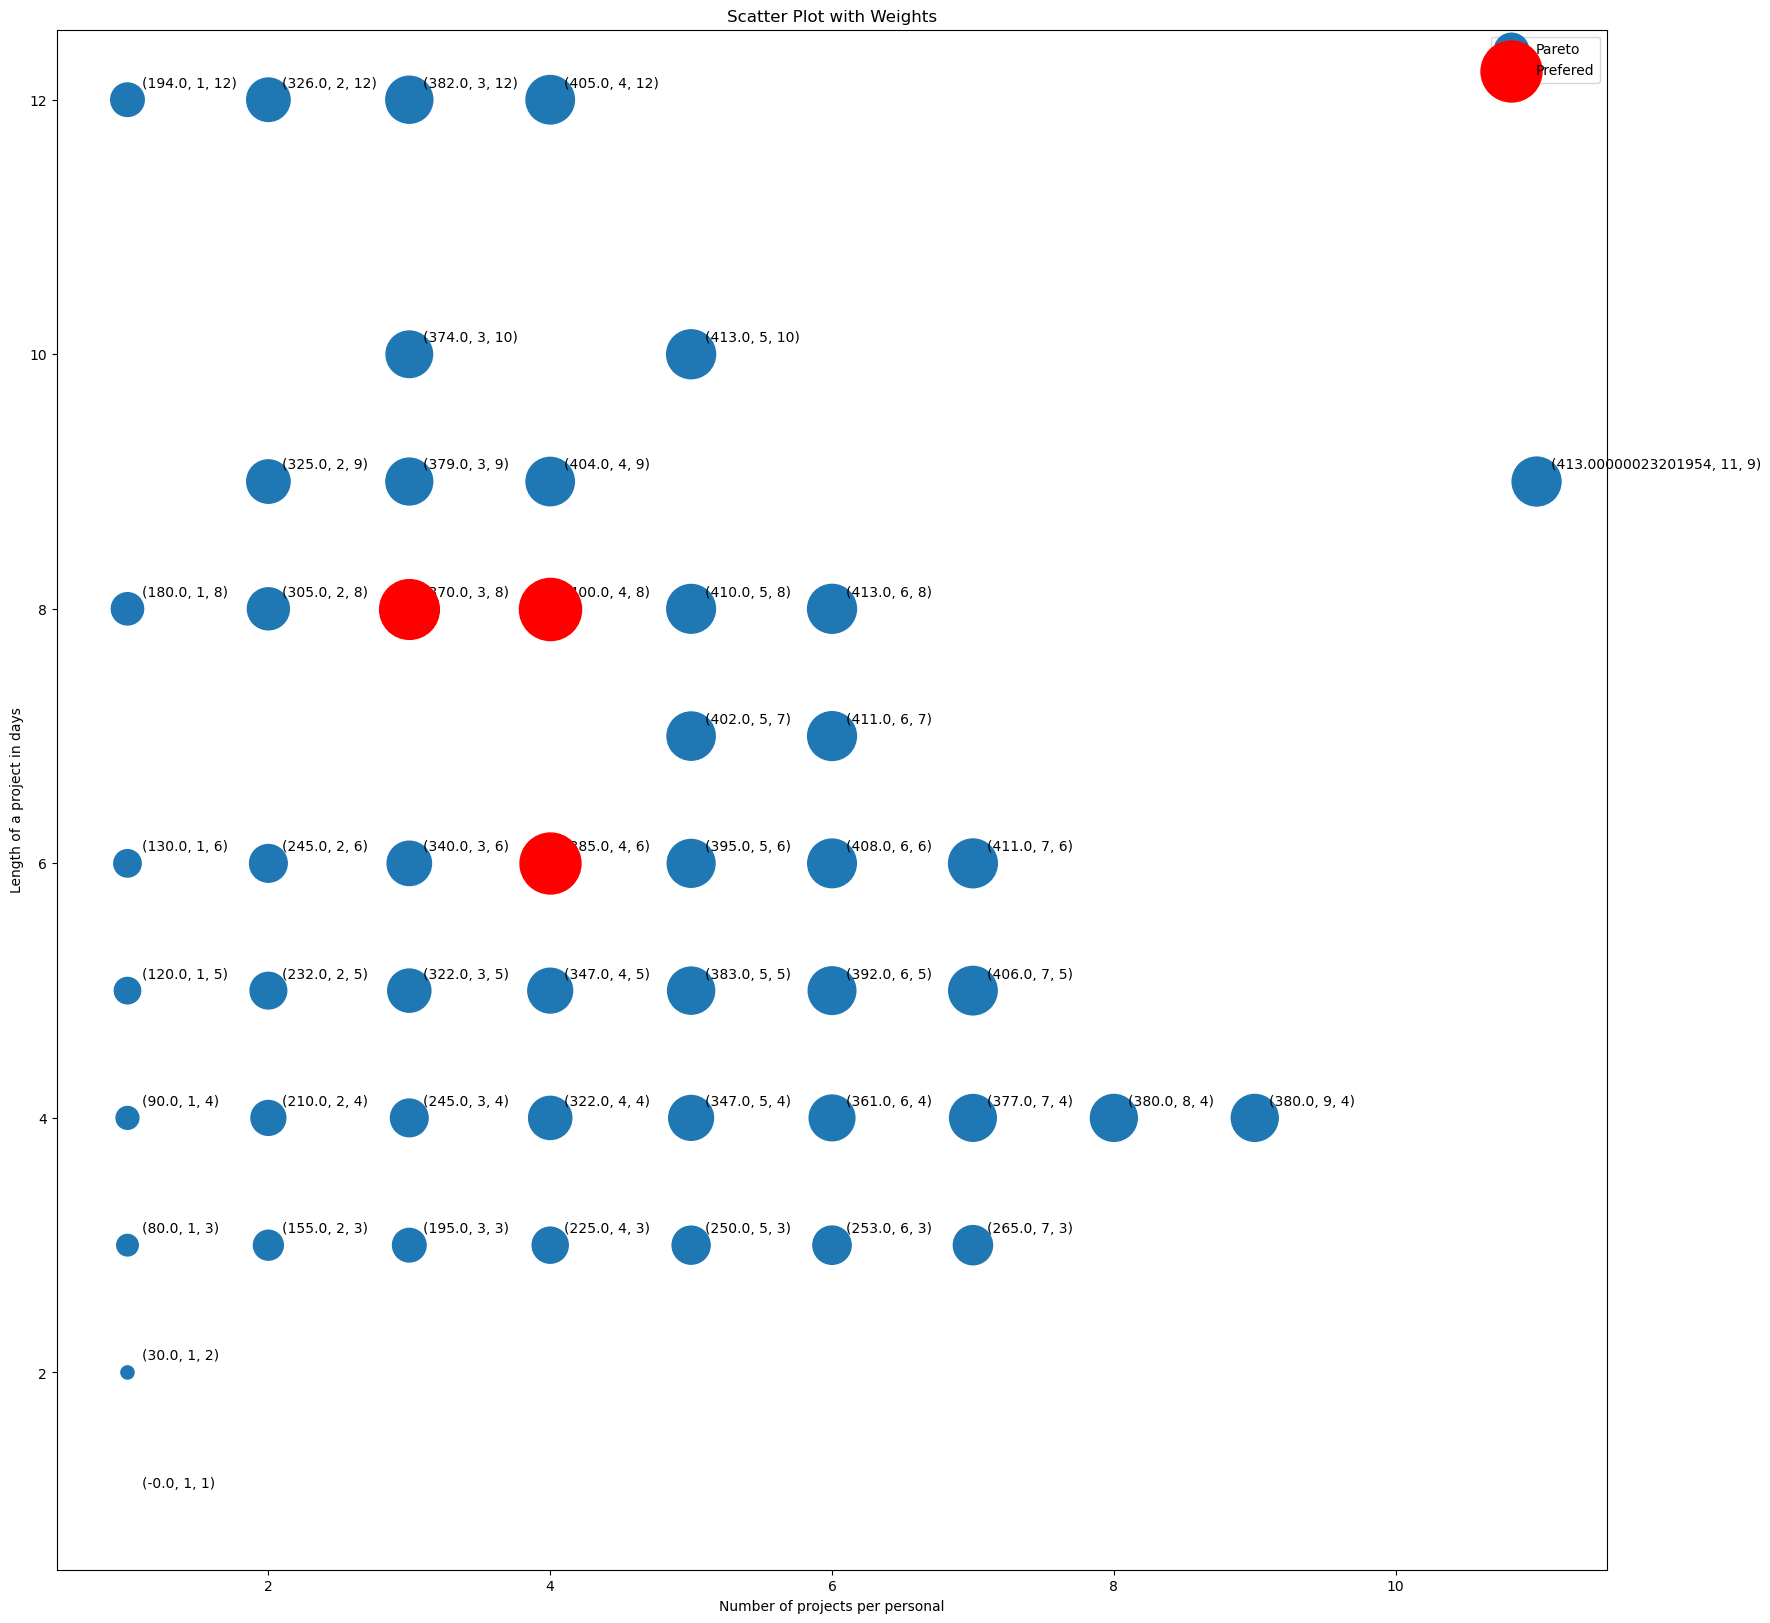

In [23]:
# Create the scatter plot
fig = plt.figure(figsize=(20,20))
plt.scatter([i[1] for i in pareto], [i[2] for i in pareto],s = [i[0]*3 for i in pareto])
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.1, i[2]+0.1,  '%s' % (str(i)), size=10, zorder=1, color='k')

# color the 3 best solutions in red according to pareto_sorted
for i in range(3):
    plt.scatter([pareto_sorted[list(pareto_sorted.keys())[i]][1]], [pareto_sorted[list(pareto_sorted.keys())[i]][2]],s = [pareto_sorted[list(pareto_sorted.keys())[i]][0]*5], color = 'red')

plt.title("Scatter Plot with Weights")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Pareto', 'Prefered'])

# Show the plot
plt.show()


In [27]:
# Borda Rule
# Rank all the solutions for each objective
# The best solution for each objective is ranked 1, the second best is ranked 2, etc.
# The sum of the ranks for each objective is the score for each solution
pareto1 = pareto.copy()
# Objective 1
pareto1.sort(key=lambda x: x[0], reverse=True)
for ind,val in enumerate(pareto1) :
    pareto1[ind] = ([ind+1],val[0],val[1],val[2])
# Objective 2
pareto1.sort(key=lambda x: x[2], reverse=True)
for ind,val in enumerate(pareto1) :
    pareto1[ind] = (val[0] + [ind +1],val[1],val[2],val[3])

# Objective 3
pareto1.sort(key=lambda x: x[3], reverse=True)
for ind,val in enumerate(pareto1) :
    pareto1[ind] = (val[0] + [ind +1],val[1],val[2],val[3])
print(pareto1)

[([50, 8, 1], -0.0, -1, -1), ([49, 7, 2], 30.0, -1, -2), ([48, 6, 3], 80.0, -1, -3), ([44, 15, 4], 155.0, -2, -3), ([41, 23, 5], 195.0, -3, -3), ([39, 30, 6], 225.0, -4, -3), ([35, 37, 7], 250.0, -5, -3), ([34, 43, 8], 253.0, -6, -3), ([33, 47, 9], 265.0, -7, -3), ([47, 5, 10], 90.0, -1, -4), ([40, 14, 11], 210.0, -2, -4), ([36, 22, 12], 245.0, -3, -4), ([30, 29, 13], 322.0, -4, -4), ([25, 36, 14], 347.0, -5, -4), ([24, 42, 15], 361.0, -6, -4), ([21, 46, 16], 377.0, -7, -4), ([19, 48, 17], 380.0, -8, -4), ([18, 49, 18], 380.0, -9, -4), ([46, 4, 19], 120.0, -1, -5), ([38, 13, 20], 232.0, -2, -5), ([31, 21, 21], 322.0, -3, -5), ([26, 28, 22], 347.0, -4, -5), ([16, 35, 23], 383.0, -5, -5), ([14, 41, 24], 392.0, -6, -5), ([8, 45, 25], 406.0, -7, -5), ([45, 3, 26], 130.0, -1, -6), ([37, 12, 27], 245.0, -2, -6), ([27, 20, 28], 340.0, -3, -6), ([15, 27, 29], 385.0, -4, -6), ([13, 34, 30], 395.0, -5, -6), ([7, 40, 31], 408.0, -6, -6), ([4, 44, 32], 411.0, -7, -6), ([11, 33, 33], 402.0, -5, -7)

In [28]:
# Sum the ranks for each solution
for ind,val in enumerate(pareto1) :
    pareto1[ind] = (sum(val[0]),val[1],val[2],val[3])

# Sort the solutions by their score
pareto1.sort(key=lambda x: x[0], reverse=False)
pareto1

[(57, 80.0, -1, -3),
 (58, 30.0, -1, -2),
 (59, -0.0, -1, -1),
 (62, 90.0, -1, -4),
 (63, 155.0, -2, -3),
 (65, 210.0, -2, -4),
 (69, 195.0, -3, -3),
 (69, 120.0, -1, -5),
 (70, 245.0, -3, -4),
 (71, 232.0, -2, -5),
 (71, 385.0, -4, -6),
 (72, 322.0, -4, -4),
 (73, 322.0, -3, -5),
 (74, 383.0, -5, -5),
 (74, 130.0, -1, -6),
 (75, 225.0, -4, -3),
 (75, 347.0, -5, -4),
 (75, 340.0, -3, -6),
 (76, 347.0, -4, -5),
 (76, 245.0, -2, -6),
 (76, 400.0, -4, -8),
 (77, 395.0, -5, -6),
 (77, 402.0, -5, -7),
 (77, 410.0, -5, -8),
 (78, 406.0, -7, -5),
 (78, 408.0, -6, -6),
 (78, 411.0, -6, -7),
 (78, 404.0, -4, -9),
 (79, 250.0, -5, -3),
 (79, 392.0, -6, -5),
 (79, 305.0, -2, -8),
 (79, 370.0, -3, -8),
 (79, 379.0, -3, -9),
 (80, 411.0, -7, -6),
 (80, 180.0, -1, -8),
 (80, 413.0, -6, -8),
 (80, 325.0, -2, -9),
 (80, 413.0, -5, -10),
 (81, 361.0, -6, -4),
 (82, 382.0, -3, -12),
 (83, 377.0, -7, -4),
 (83, 405.0, -4, -12),
 (84, 380.0, -8, -4),
 (85, 253.0, -6, -3),
 (85, 380.0, -9, -4),
 (85, 374.0

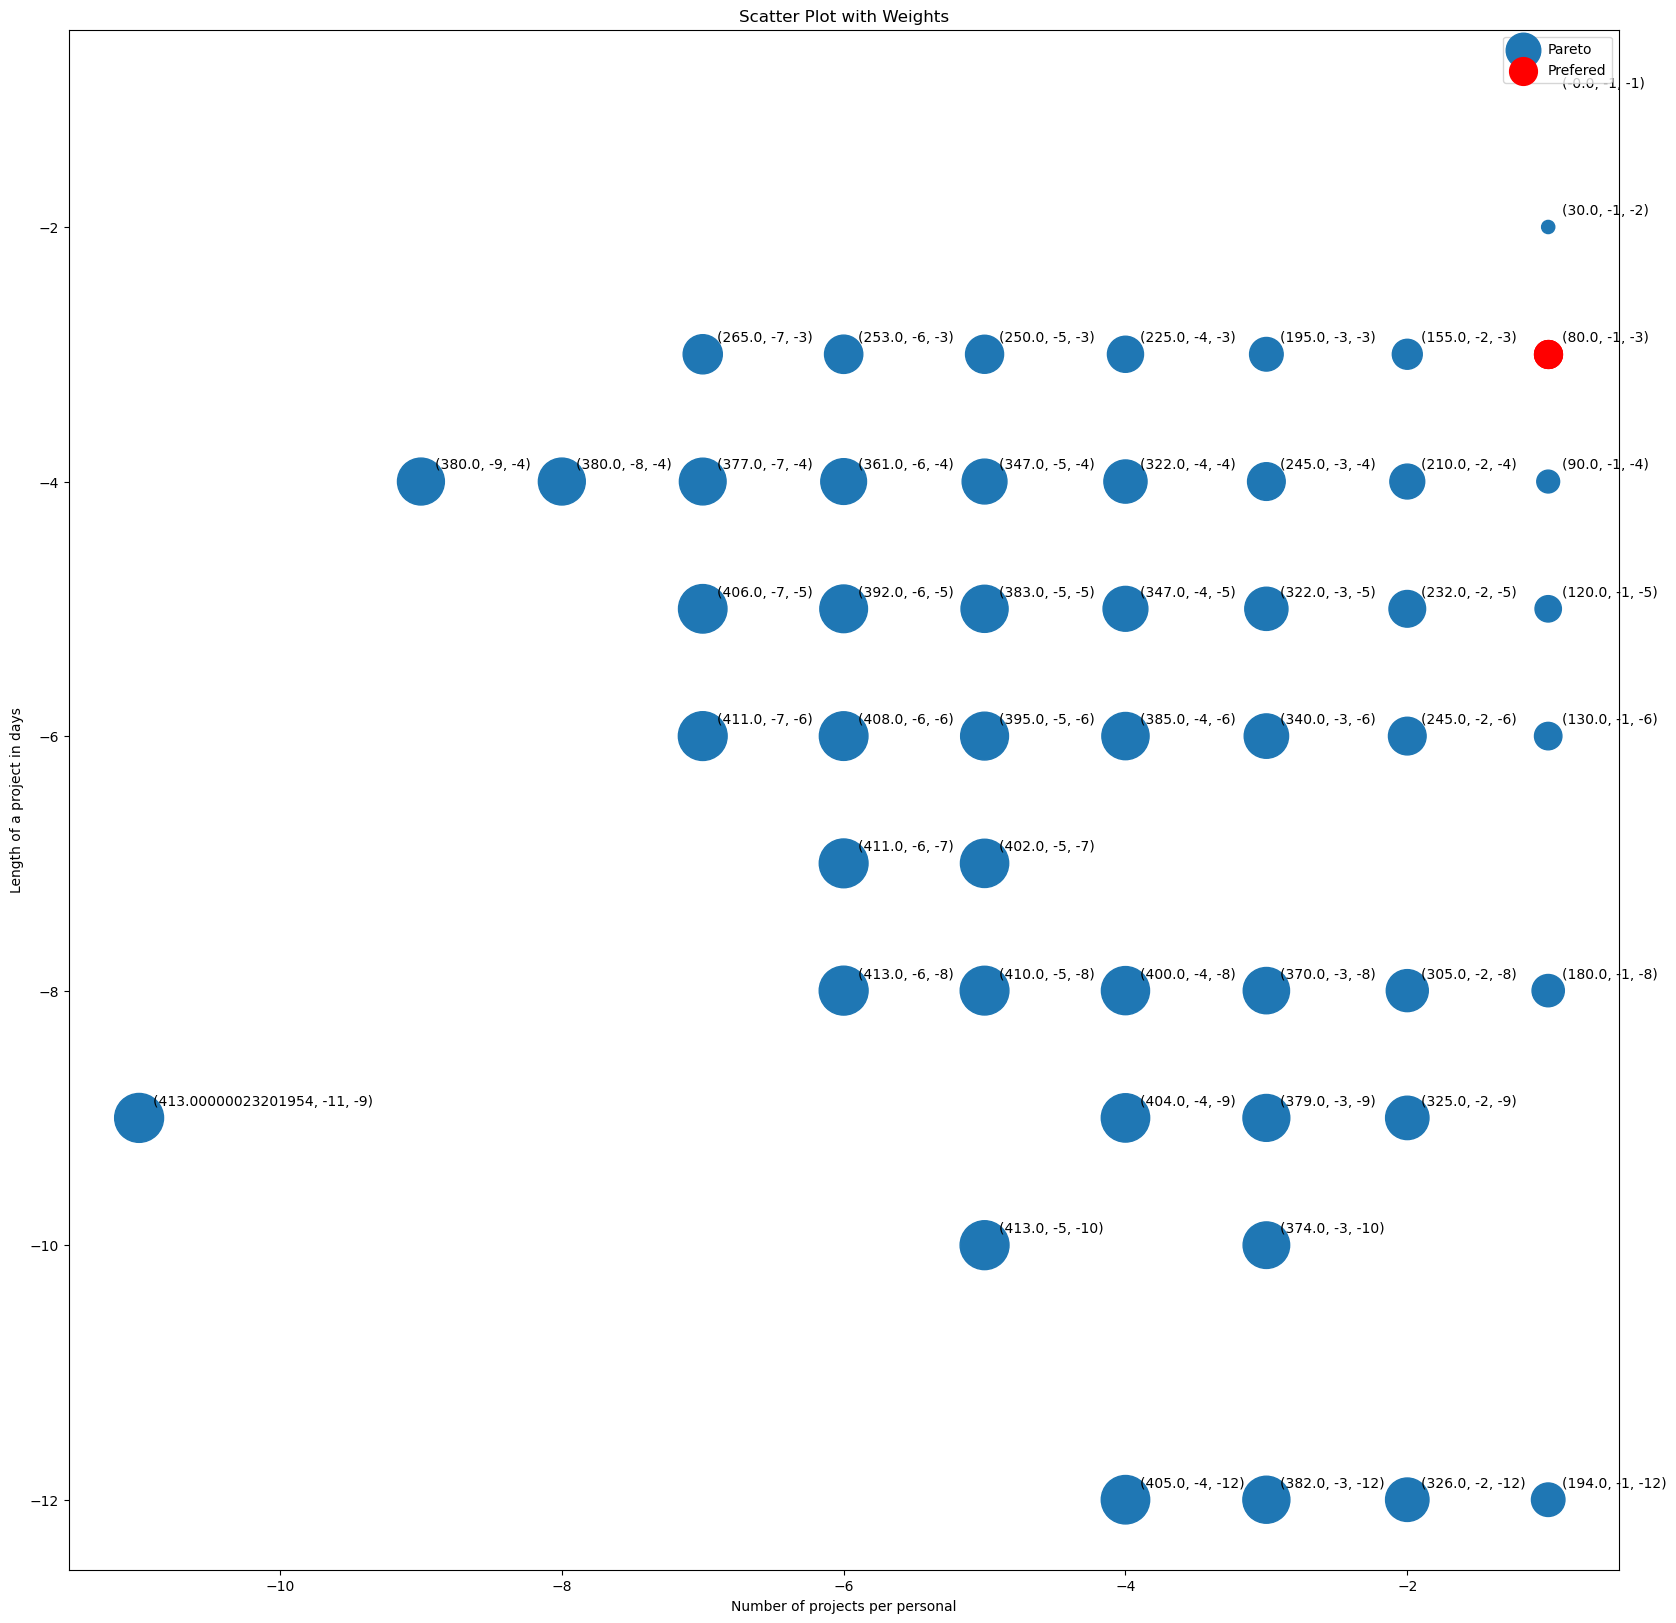

In [29]:
# Create the scatter plot
fig = plt.figure(figsize=(20,20))
plt.scatter([i[1] for i in pareto], [i[2] for i in pareto],s = [i[0]*3 for i in pareto])
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.1, i[2]+0.1,  '%s' % (str(i)), size=10, zorder=1, color='k')

# color the 3 best solutions in red according to pareto_sorted
for i in range(3):
    plt.scatter([pareto1[0][2]], [pareto1[0][3]],s = [pareto1[0][1]*5], color = 'red')

plt.title("Scatter Plot with Weights")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Pareto', 'Prefered'])

# Show the plot
plt.show()

In [32]:
# From the 3 objectives, we want to split the solutions into 3 groups of solutions : unacceptable, acceptable and optimal
# We set limits for each objective to split the solutions into 3 groups
# The limits are the 25th and 75th percentiles of the maximum values of each objective
# The solutions that are below the 25th percentile are unacceptable
# The solutions that are between the 25th and 75th percentiles are acceptable
# The solutions that are above the 75th percentile are optimal


unacceptable = []
acceptable = []
optimal = []

# Split the solutions using the 3 objectives together

q1_obj1 = 0.5 * sum(gj.values())
q3_obj1 = 0.75 *sum(gj.values())
q1_obj2 = -0.75 * len(J)
q3_obj2 = -0.5 * len(J)
q1_obj3 = -0.75 * len(H)
q3_obj3 = -0.5 * len(H)
print(q1_obj1, q3_obj1, q1_obj2, q3_obj2, q1_obj3, q3_obj3)

for i in pareto:
    if i[0] <= q1_obj1 or i[1] <= q1_obj2 or i[2] <= q1_obj3:
        unacceptable.append(i)
    elif i[0] >= q3_obj1 and i[1] >= q3_obj2 and i[2] >= q3_obj3:
        optimal.append(i)
    else:
        acceptable.append(i)



print("Unacceptable solutions : ", unacceptable)
print("Acceptable solutions : ", acceptable)
print("Optimal solutions : ", optimal)









255.0 382.5 -11.25 -7.5 -16.5 -11.0
Unacceptable solutions :  [(253.0, -6, -3), (250.0, -5, -3), (225.0, -4, -3), (245.0, -3, -4), (195.0, -3, -3), (245.0, -2, -6), (232.0, -2, -5), (210.0, -2, -4), (155.0, -2, -3), (194.0, -1, -12), (180.0, -1, -8), (130.0, -1, -6), (120.0, -1, -5), (90.0, -1, -4), (80.0, -1, -3), (30.0, -1, -2), (-0.0, -1, -1)]
Acceptable solutions :  [(413.00000023201954, -11, -9), (380.0, -9, -4), (380.0, -8, -4), (377.0, -7, -4), (265.0, -7, -3), (361.0, -6, -4), (347.0, -5, -4), (405.0, -4, -12), (347.0, -4, -5), (322.0, -4, -4), (382.0, -3, -12), (374.0, -3, -10), (379.0, -3, -9), (370.0, -3, -8), (340.0, -3, -6), (322.0, -3, -5), (326.0, -2, -12), (325.0, -2, -9), (305.0, -2, -8)]
Optimal solutions :  [(411.0, -7, -6), (406.0, -7, -5), (413.0, -6, -8), (411.0, -6, -7), (408.0, -6, -6), (392.0, -6, -5), (413.0, -5, -10), (410.0, -5, -8), (402.0, -5, -7), (395.0, -5, -6), (383.0, -5, -5), (404.0, -4, -9), (400.0, -4, -8), (385.0, -4, -6)]


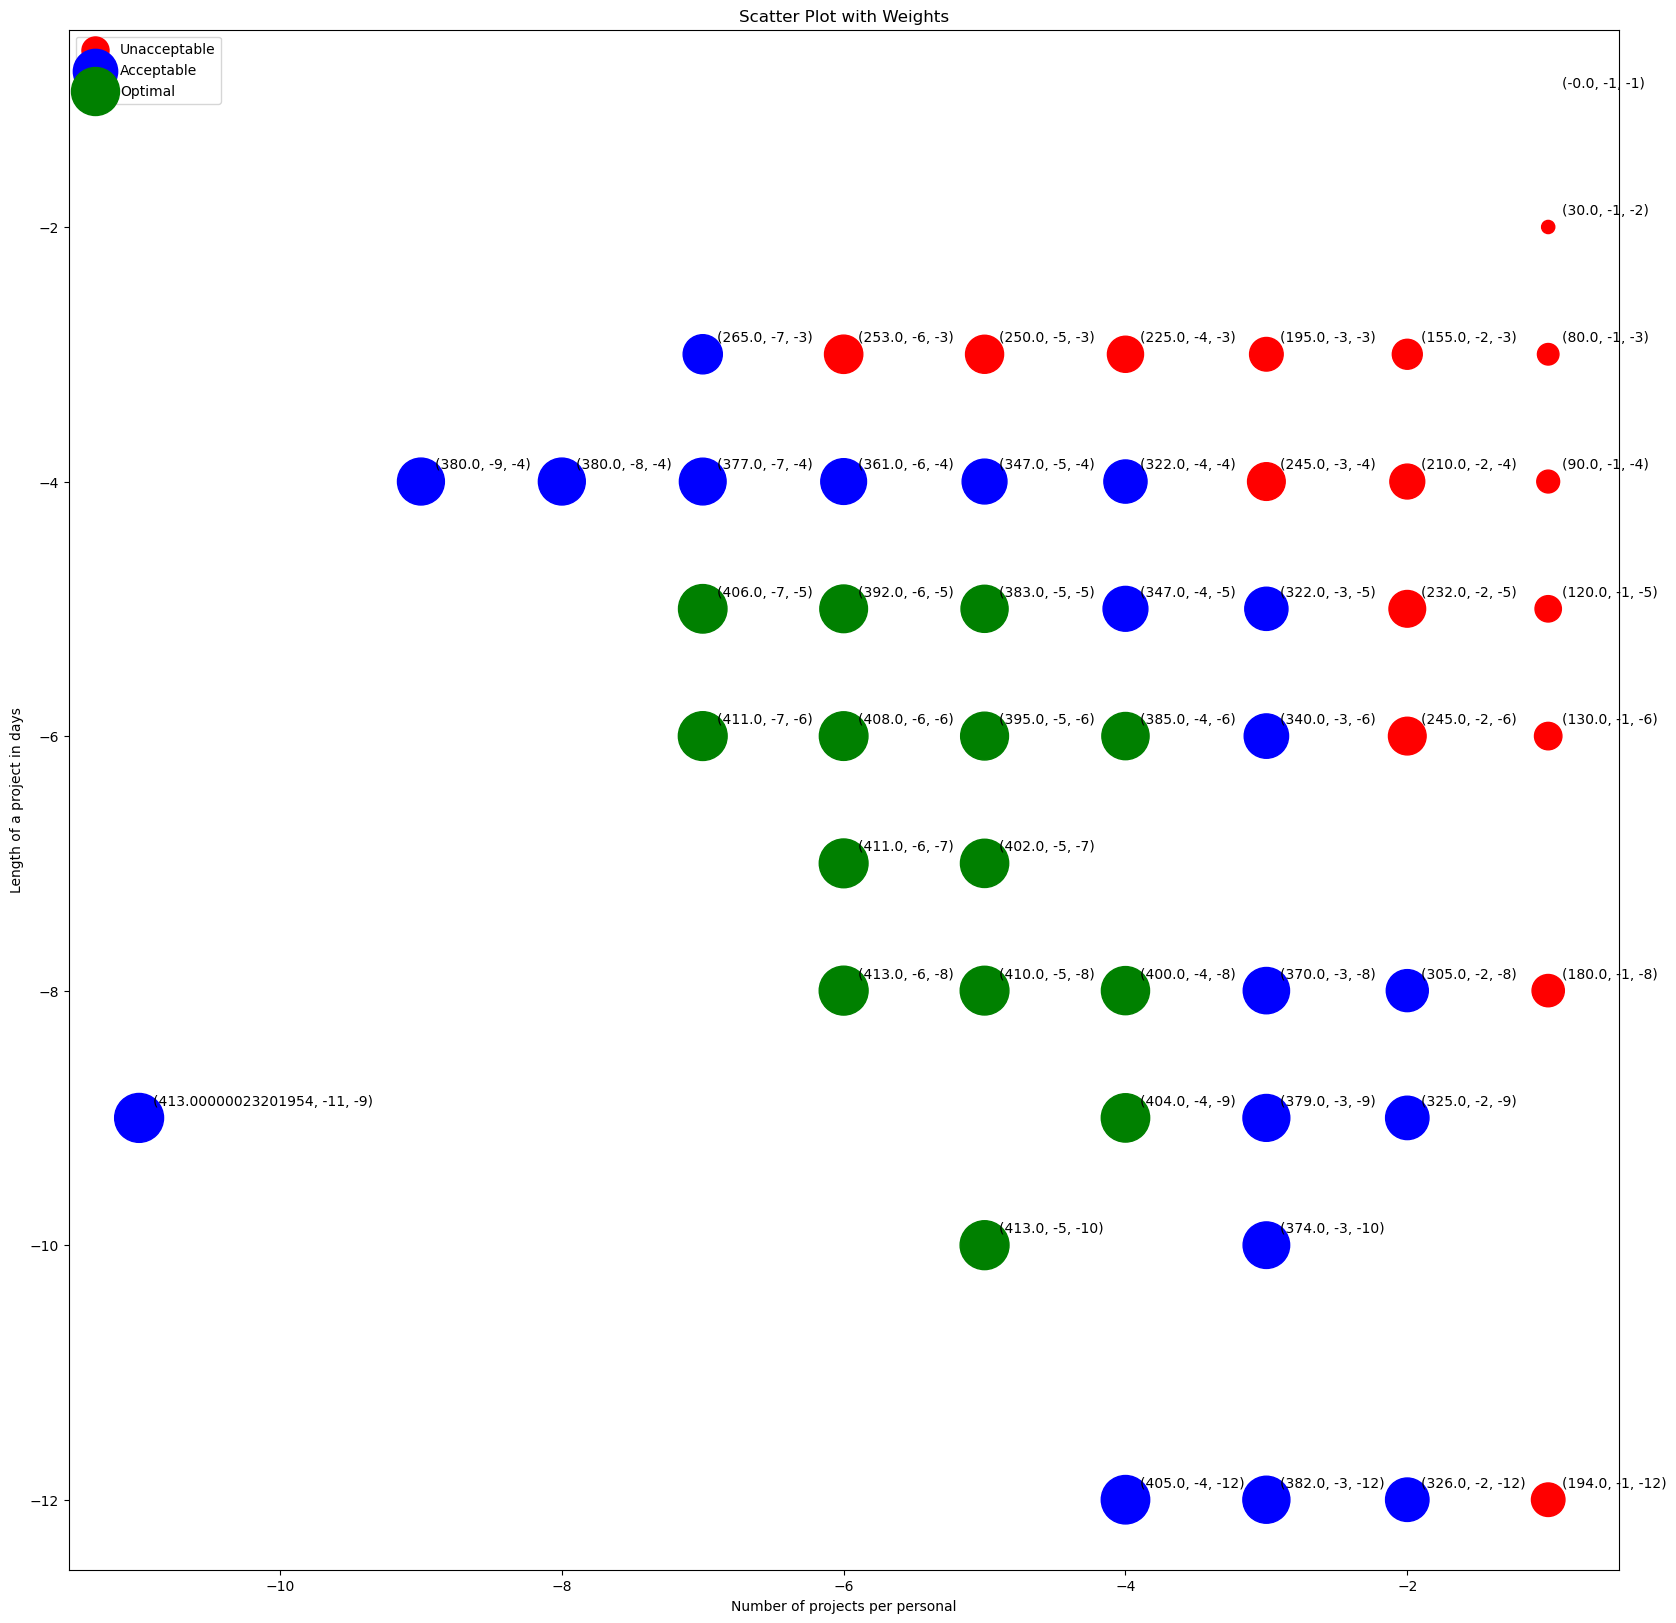

In [33]:
# Create the scatter plot
fig = plt.figure(figsize=(20,20))
plt.scatter([i[1] for i in unacceptable], [i[2] for i in unacceptable],s = [i[0]*3 for i in unacceptable],color= 'r')
plt.scatter([i[1] for i in acceptable], [i[2] for i in acceptable],s = [i[0]*3 for i in acceptable], color = 'b')
plt.scatter([i[1] for i in optimal], [i[2] for i in optimal],s = [i[0]*3 for i in optimal], color = 'g')
# Add a title and labels for the x and y axes
for i in pareto:
    plt.text(i[1] + 0.1, i[2]+0.1,  '%s' % (str(i)), size=10, zorder=1, color='k')



plt.title("Scatter Plot with Weights")
plt.xlabel("Number of projects per personal")
plt.ylabel("Length of a project in days")
plt.legend(['Unacceptable', 'Acceptable','Optimal'])

# Show the plot
plt.show()